In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels
import matplotlib.pyplot as plt

## Задача 6 

- Загрузите и визуализируйте временной ряд
- Постройте график временного ряда.
- Сделайте краткий вывод: видны ли тренды, сезонность, выбросы?

In [79]:
df = pd.read_csv('../data/05-1-arima-data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sample(5)

,Value
Date,
2015-10-31,-0.645120
2012-05-31,-0.600639
2010-11-30,-0.463418
2017-06-30,0.513267
2016-10-31,0.357113


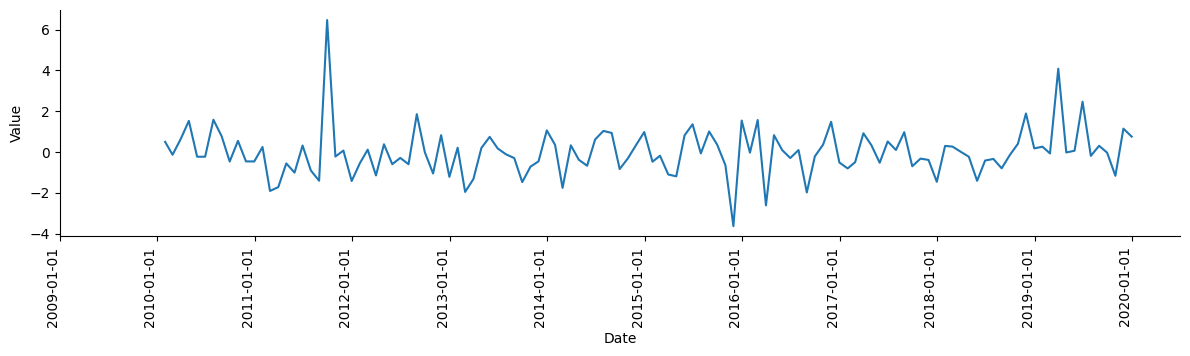

In [78]:
# Тренда нет, сезонность есть, выбросы есть
g = sns.relplot(x=df.index, y=df['Value'], kind='line', height=3, aspect=4)
g.set_xticklabels(rotation=90, horizontalalignment="right", step=1);

- Проверьте стационарность ряда. Напишите функцию, реализующую тест Дики-Фуллера. Проведите тест на стационарность.

In [80]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Value'].dropna())
print(f"p-value: {result[1]}")
if result[1] < 0.05:
	print("Ряд стационарен.")
else:
	print("Ряд нестационарен.")

p-value: 3.4079239097508516e-21
Ряд стационарен.


- Постройте графики автокорреляции (ACF) и частичной автокорреляции (PACF).Проанализируйте их и определите:
    - После какого лага обрывается ACF? → это будет `q`
    - После какого лага обрывается PACF? → это будет `p`

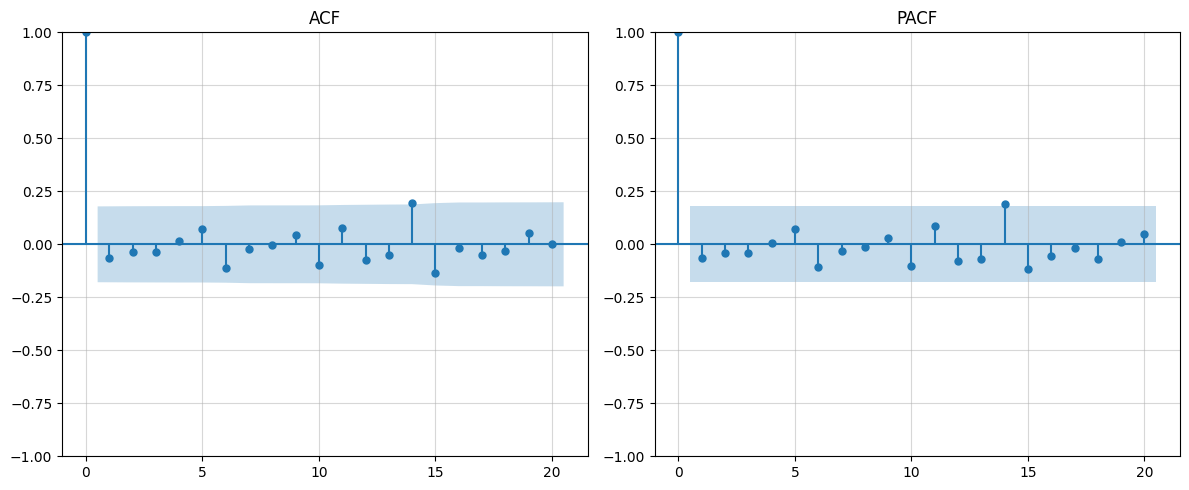

In [84]:
# ACF=q=2 & PACF=p=2
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ts = df['Value']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_acf(ts, ax=ax1, lags=20)
ax1.grid(True, alpha=0.5)
ax1.set_title("ACF")

plot_pacf(ts, ax=ax2, lags=20, method='ywm')
ax2.grid(True, alpha=0.5)
ax2.set_title("PACF")

plt.tight_layout()
plt.show()

- Разделите данные на обучающую и тестовую выборки в пропорции 80/20

In [85]:
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

- Обучите модель ARIMA с параметрами (`p`, `d`, `q`), полученными ранее. Выведите сводку модели.

In [86]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(2, 0, 2)) # (p,d,q)
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                   96
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -146.921
Date:                Tue, 28 Oct 2025   AIC                            305.841
Time:                        22:59:47   BIC                            321.227
Sample:                    01-31-2010   HQIC                           312.061
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1254      0.017     -7.390      0.000      -0.159      -0.092
ar.L1         -0.2270      0.130     -1.747      0.081      -0.482       0.028
ar.L2          0.7205      0.137      5.250      0.0

/Users/skv/PycharmProjects/study-timeseries-analysis-forecasting/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/skv/PycharmProjects/study-timeseries-analysis-forecasting/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/skv/PycharmProjects/study-timeseries-analysis-forecasting/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/skv/PycharmProjects/study-timeseries-analysis-forecasting/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_re

- Получите прогноз и постройте график

In [87]:
forecast = model_fit.forecast(steps=len(test))
forecast.index = test.index

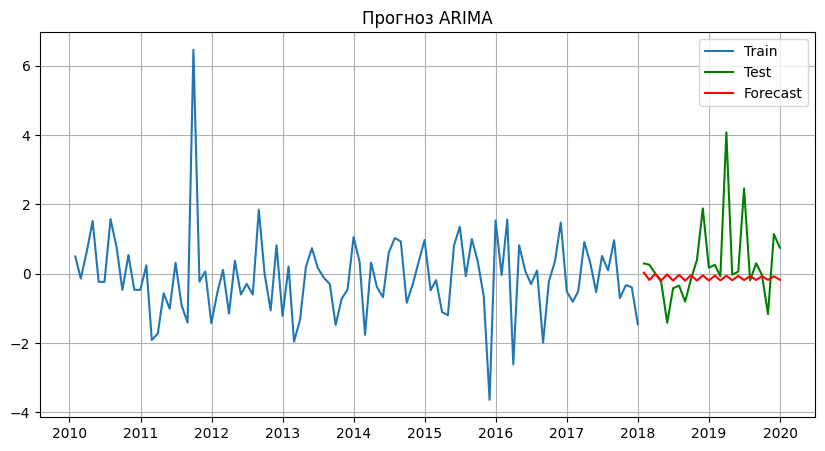

In [88]:
plt.figure(figsize=(10, 5))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='green')
plt.plot(forecast, label='Forecast', color='red')
plt.title('Прогноз ARIMA')
plt.legend()
plt.grid()
plt.show()

- Рассчитайте метрики и выведите результат

In [89]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test, forecast)

print("MAE:", round(mae, 4))
print("MSE:", round(mse, 4))
print("RMSE:", round(rmse, 4))
print("MAPE:", round(mape * 100, 2), '%')

MAE: 0.7329
MSE: 1.4524
RMSE: 1.2052
MAPE: 131.74 %


- Сравните с другой моделью. 
    - Обучите вторую модель ARIMA с другими параметрами (например, (3,0,3)).
    - Повторите шаги: прогноз → визуализация → метрики.
    - Сравните: какая модель точнее?

In [90]:
def pipelin(data, order=(0,0,0)):
    train_size = int(len(ts) * 0.8)
    train, test = data[:train_size], data[train_size:]

    model = ARIMA(train, order=order) # (p,d,q)
    model_fit = model.fit()

    forecast = model_fit.forecast(steps=len(test))
    forecast.index = test.index

    plt.figure(figsize=(10, 5))
    plt.plot(train, label='Train')
    plt.plot(test, label='Test', color='green')
    plt.plot(forecast, label='Forecast', color='red')
    plt.title('Прогноз ARIMA')
    plt.legend()
    plt.grid()
    plt.show()

    mae = mean_absolute_error(test, forecast)
    mse = mean_squared_error(test, forecast)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(test, forecast)

    print("MAE:", round(mae, 4))
    print("MSE:", round(mse, 4))
    print("RMSE:", round(rmse, 4))
    print("MAPE:", round(mape * 100, 2), '%')

/Users/skv/PycharmProjects/study-timeseries-analysis-forecasting/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/skv/PycharmProjects/study-timeseries-analysis-forecasting/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/skv/PycharmProjects/study-timeseries-analysis-forecasting/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/skv/PycharmProjects/study-timeseries-analysis-forecasting/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as

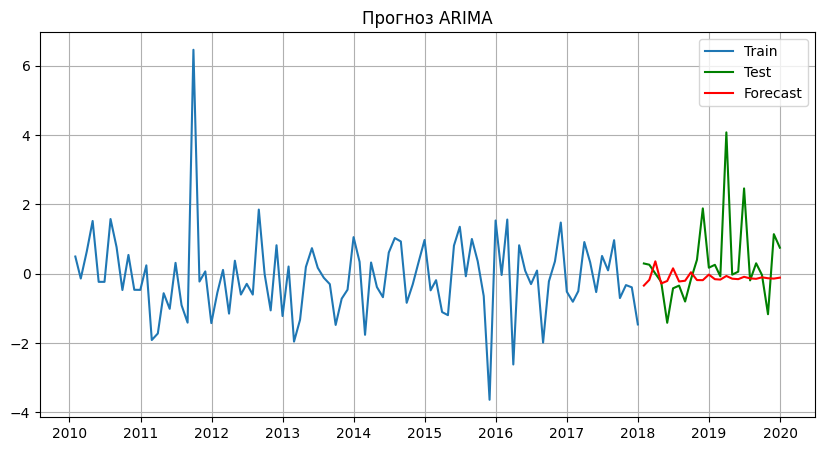

MAE: 0.7642
MSE: 1.4679
RMSE: 1.2116
MAPE: 421.85 %


In [ ]:
pipelin(data=ts, order=(3,0,3))

- Прогноз на будущее
    - Постройте прогноз на 20 шагов вперёд после конца ряда.
    - Постройте график с последними значениями и будущим прогнозом.